# **TASK 4**

MIS

An independent set is a set of vertices in a graph such that no two of which are connected by an edge. The problem of finding Maximum Independent Sets (MIS) is NP-hard. In this task, you will solve small instances of the MIS with gate and analog-based quantum computing: 

1) Create 4 graphs with 3, 5, 6, and 7 nodes. You can define the edges as you prefer. 
2) For each graph, find the MIS using the following methods: 
    1) The Gate-Based QAOA  
    2) The Quantum adiabatic algorithm using analog based quantum computing. You can check the documentation in Pulser and Blockade for references. 
3) Compared the results 


# **GATE BASED QAOA**

## Overview

The code provided leverages a combination of Python packages to solve the Maximum Independent Set (MIS) problem on graphs using quantum computing techniques, specifically the Quantum Approximate Optimization Algorithm (QAOA). The workflow includes graph generation, model formulation, optimization with QAOA, and visualization of results.

In [46]:
pip install -U classiq

  Obtaining dependency information for classiq from https://files.pythonhosted.org/packages/73/99/f2a4c2384bd8cfc86ac275da6e5caf3594f29c257871edbf68d0ba3d0f78/classiq-0.38.0-py3-none-any.whl.metadata
  Obtaining dependency information for ConfigArgParse<2.0.0,>=1.5.3 from https://files.pythonhosted.org/packages/6f/b3/b4ac838711fd74a2b4e6f746703cf9dd2cf5462d17dac07e349234e21b97/ConfigArgParse-1.7-py3-none-any.whl.metadata
  Obtaining dependency information for Pyomo<6.6,>=6.5 from https://files.pythonhosted.org/packages/35/d8/295009646d274c3093c69c6187527dc74152b4d9875be9da5db999e6050e/Pyomo-6.5.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for httpx<1,>=0.23.0 from https://files.pythonhosted.org/packages/41/7b/ddacf6dcebb42466abd03f368782142baa82e08fc0c1f8eaa05b4bae87d5/httpx-0.27.0-py3-none-any.whl.metadata
  Obtaining dependency information for packaging<22.0,>=21.3 from https://files.pythonhosted.org/packages/05/8e/8de486cbd03baba4deef4142bd643a3e7bbe954a78

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dwave-cloud-client 0.11.0 requires homebase>=1.0, which is not installed.
dwave-cloud-client 0.11.0 requires plucky>=0.4.3, which is not installed.
dwave-system 1.21.0 requires homebase<2.0.0,>=1.0.0, which is not installed.
streamlit 1.30.0 requires pydeck<1,>=0.8.0b4, which is not installed.
streamlit 1.30.0 requires tzlocal<6,>=1.1, which is not installed.
streamlit 1.30.0 requires validators<1,>=0.2, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
dwave-cloud-client 0.11.0 requires pydantic<3,>=2, but you have pydantic 1.10.14 which is incompatible.
black 0.0 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
pydantic-settings 2.2.1 requires pydantic>=2.3.0, but you have pydantic 1.10.1

## Libraries and Frameworks

- `classiq`: A platform for generating and executing quantum algorithms.
- `networkx`: Used for graph creation and manipulation.
- `numpy`: A fundamental package for scientific computing with Python.
- `pyomo`: An open-source Python library for defining and solving mathematical models.
- `matplotlib`: A plotting library for creating static, interactive, and animated visualizations in Python.


<h2>Authentication</h2>
<p>This part of the code authenticates the user with the Classiq platform and prints the directory of available functions and classes in the Classiq module.</p>

In [48]:
import classiq

classiq.authenticate()

c:\Users\riakh\AppData\Local\anaconda3\Lib\site-packages\classiq\_internals\authentication\token_manager.py:96: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [49]:
print(dir(classiq))

['Analyzer', 'Array', 'AuxQReg', 'CCX', 'CH', 'CPHASE', 'CRX', 'CRY', 'CRZ', 'CX', 'CY', 'CZ', 'ChemistryAtom', 'CombinatorialOptimizationSolution', 'Constraints', 'ControlState', 'CustomHardwareSettings', 'ExecutionParams', 'FinanceFunction', 'FockHamiltonianProblem', 'ForeignFunctionDefinition', 'FunctionGenerator', 'FunctionImplementation', 'FunctionLibrary', 'GaussianModel', 'H', 'I', 'IDENTITY', 'Input', 'LadderOp', 'LadderTerm', 'LogNormalModel', 'Model', 'Molecule', 'MoleculeProblem', 'OptimizationParameter', 'Output', 'PHASE', 'Pauli', 'PauliTerm', 'Position', 'Preferences', 'QASM3_INTRO', 'QASM_INTRO', 'QArray', 'QBit', 'QCallable', 'QCallableList', 'QConstant', 'QNum', 'QParam', 'QReg', 'QSFixed', 'QSInt', 'QSVMFeatureMapPauli', 'QUFixed', 'QUInt', 'QsvmResult', 'QuantumFunction', 'QuantumFunctionFactory', 'QuantumProgram', 'R', 'RX', 'RXX', 'RY', 'RYY', 'RZ', 'RZZ', 'Register', 'RegisterArithmeticInfo', 'RegisterMappingData', 'RegisterUserInput', 'S', 'SDG', 'SWAP', 'T', 'TD

In [50]:
from typing import cast

import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

<h2>Maximum Independent Set (MIS) Model</h2>
<p>This function defines a Pyomo concrete model for the MIS problem. It creates a binary variable for each node to indicate whether it's part of the independent set. A constraint ensures that no two adjacent nodes are both in the set. The objective is to maximize the sum of the variables, representing the size of the independent set.</p>


In [52]:
import networkx as nx
import pyomo.core as pyo


def mis(graph: nx.Graph) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)

    @model.Constraint(graph.edges)
    def independent_rule(model, node1, node2):
        return model.x[node1] + model.x[node2] <= 1

    model.cost = pyo.Objective(expr=sum(model.x.values()), sense=pyo.maximize)

    return model

<h2>Graph Generation and Visualization</h2>
<p>This snippet generates a random graph with a specified number of nodes and probability of edge creation. It visualizes the graph using NetworkX's <code>draw_kamada_kawai</code> function.</p>


# For number of vertices = 3

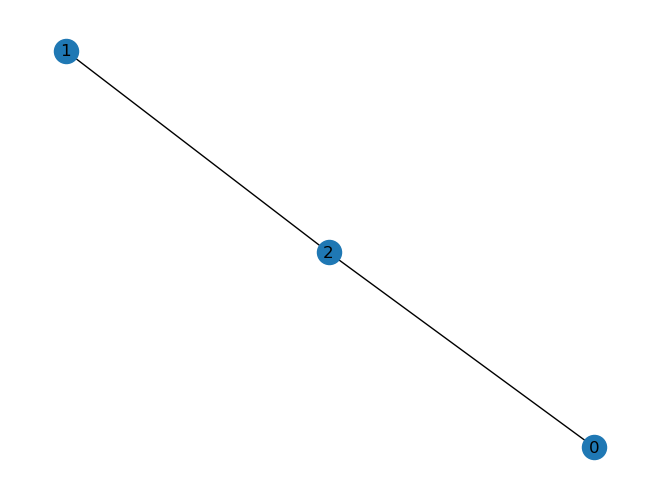

In [70]:
import networkx as nx

num_nodes = 3
p_edge = 0.4
graph = nx.fast_gnp_random_graph(n=num_nodes, p=p_edge, seed=12345)

nx.draw_kamada_kawai(graph, with_labels=True)
mis_model = mis(graph)

In [71]:
mis_model.pprint()

2 Set Declarations
    independent_rule_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    2 : {(0, 2), (1, 2)}
    x_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}

1 Var Declarations
    x : Size=3, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : x[0] + x[1] + x[2]

1 Constraint Declarations
    independent_rule : Size=2, Index=independent_rule_index, Active=True
        Key    : Lower : Body        : Upper : Active
        (0, 2) :  -Inf : x[0] + x[2] :   1.0 :   True


<h2>QAOA Model Construction</h2>
<p>This code configures the QAOA parameters and optimization settings, then constructs a QAOA model using the Classiq framework.</p>


In [72]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3)

In [73]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

In [74]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=mis_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

<h2>Execution Preferences and Synthesis</h2>
<p>The code sets preferences for quantum execution on the desired backend, synthesizes a quantum program from the model, and displays the generated program.</p>


In [75]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [76]:
with open("max_independent_set.qmod", "w") as f:
    f.write(qmod)

In [77]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/88ac478d-4122-4d40-91c7-c60946f0efa2?version=0.38.0


<h2>Solution Extraction and Analysis</h2>
<p>Here, the solution to the MIS problem is extracted, and the results are analyzed to identify the independent set with the highest cost (size). The independent set is then printed and visualized on the graph.</p>

In [78]:
from classiq import execute

res = execute(qprog).result()

# The graph indicates:

X-axis (Iterations): The horizontal axis represents the number of iterations or steps in the algorithm. Each iteration orresponds to an attempt to minimize or find the lowest energy state of a quantum system.

Y-axis (Energy): The vertical axis measures the energy of the system. In the context of quantum algorithms likE QAOA, this would represent the expected value of the Hamiltonian (a measure of energy) for a given state of the quantum system.

Energy Convergence: The title "Energy convergence" suggests that the graph is showing how the energy of the system evolves as the algorithm proceeds.

# Looking at the graph:

Initial Fluctuations: The energy initially shows large fluctuations. This could be due to the algorithm exploring the solution space and making significant adjustments to the parameters that define the quantum state.

Stabilization: After the initial fluctuations, the energy begins to stabilize. This suggests that the algorithm is homing in on an optimal solution or the ground state (the state of lowest possible energy).

Convergence: The relatively flat line towards the right-hand side of the graph indicates that the energy has converged to a stable value. This means that further iterations do not yield a significant reduction in energy, suggesting that the algorithm has potentially found an optimal or near-optimal solution.

In summary, the graph is used to track the performance and progress of a quantum algorithm as it attempts to find the lowest energy state of a system, which often corresponds to the optimal solution to the problem being addressed. The stabilization and flat-lining of the energy graph is a positive sign that the algorithm is performing as expected, reaching convergence to a solution.

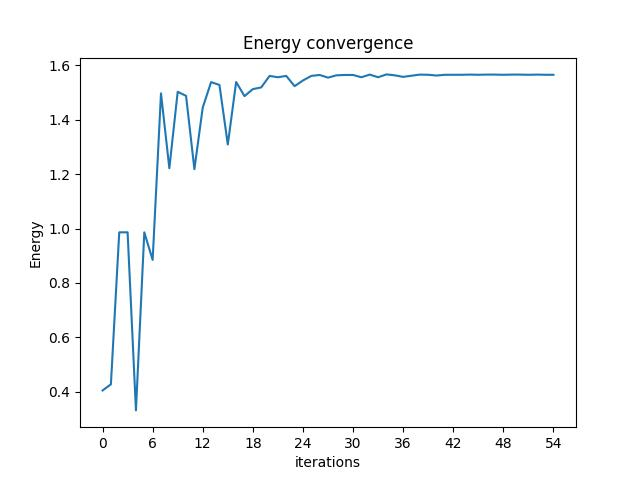

In [79]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

<h2>Extracting the Best Solution</h2>
<p>
  The best solution, corresponding to the largest independent set found by the quantum algorithm, is identified from the DataFrame. This independent set is then extracted and both its contents and size are printed for the user.
</p>


In [80]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    mis_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
0,0.395996,2.0,"[1, 1, 0]",811
1,0.332031,1.0,"[0, 0, 1]",680
6,0.005371,1.0,"[1, 0, 0]",11
7,0.005371,1.0,"[0, 1, 0]",11
2,0.157715,-0.0,"[0, 0, 0]",323


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

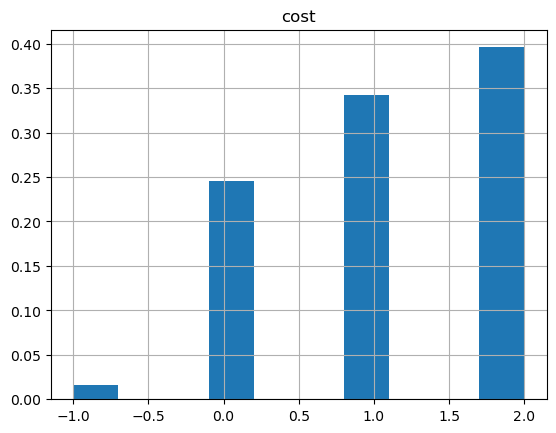

In [81]:
optimization_result.hist("cost", weights=optimization_result["probability"])

In [82]:
best_solution = optimization_result.solution[optimization_result.cost.idxmax()]

In [83]:
independent_set = [node for node in graph.nodes if best_solution[node] == 1]
print("Independent Set: ", independent_set)
print("Size of Independent Set: ", len(independent_set))

Independent Set:  [0, 1]
Size of Independent Set:  2


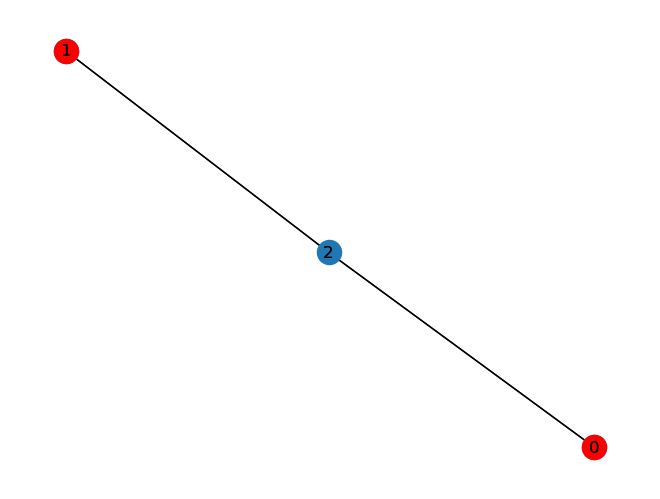

In [84]:
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=independent_set,
    node_color="r",
)

# For number of vertices = 5 , same steps as done previously are repeated

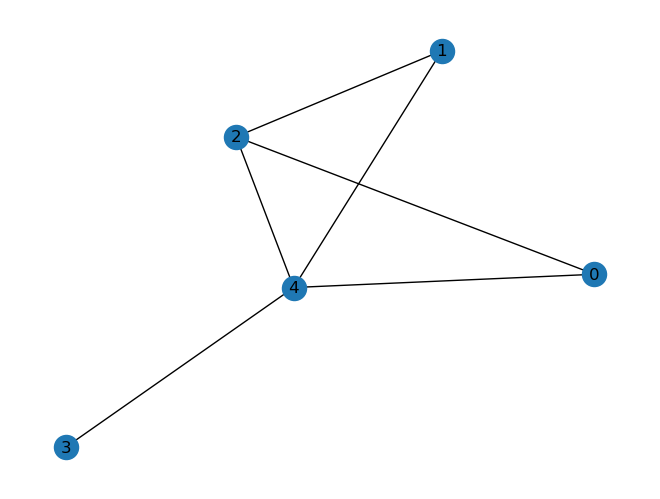

In [97]:
import networkx as nx

num_nodes = 5
p_edge = 0.4
graph = nx.fast_gnp_random_graph(n=num_nodes, p=p_edge, seed=12345)

nx.draw_kamada_kawai(graph, with_labels=True)
mis_model = mis(graph)

In [98]:
mis_model.pprint()

2 Set Declarations
    independent_rule_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    6 : {(0, 2), (0, 4), (1, 2), (1, 4), (2, 4), (3, 4)}
    x_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {0, 1, 2, 3, 4}

1 Var Declarations
    x : Size=5, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : x[0] + x[1] + x[2] + x[3] + x[4]

1 Constraint Declarations
    ind

In [99]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3)

In [100]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3)

In [101]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

In [102]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3)

In [103]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

In [104]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=mis_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

In [105]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [106]:
with open("max_independent_set.qmod", "w") as f:
    f.write(qmod)

In [107]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/8669ec6c-becd-4c80-846b-5bb323b03948?version=0.38.0


In [108]:
from classiq import execute

res = execute(qprog).result()

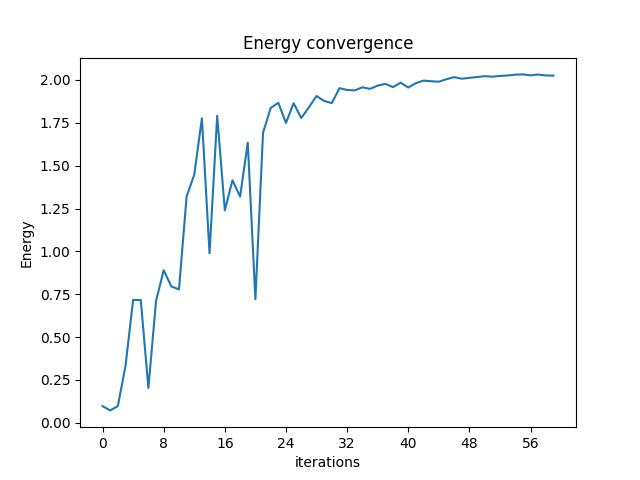

In [109]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

In [110]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    mis_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
0,0.281738,3.0,"[1, 1, 0, 1, 0]",577
5,0.035156,2.0,"[0, 1, 0, 1, 0]",72
17,0.017090,2.0,"[0, 0, 1, 1, 0]",35
1,0.127930,2.0,"[1, 1, 0, 0, 0]",262
3,0.042480,2.0,"[1, 0, 0, 1, 0]",87


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

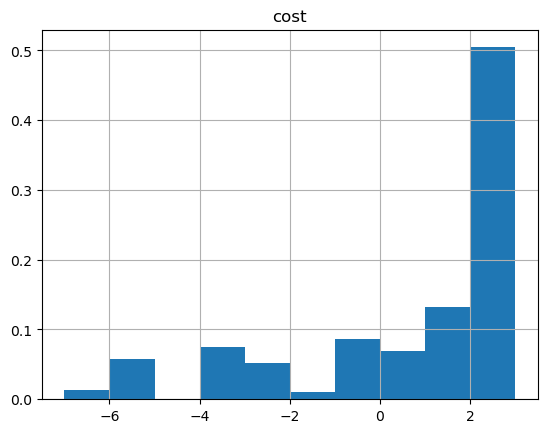

In [111]:
optimization_result.hist("cost", weights=optimization_result["probability"])

In [112]:
best_solution = optimization_result.solution[optimization_result.cost.idxmax()]

In [113]:
independent_set = [node for node in graph.nodes if best_solution[node] == 1]
print("Independent Set: ", independent_set)
print("Size of Independent Set: ", len(independent_set))

Independent Set:  [0, 1, 3]
Size of Independent Set:  3


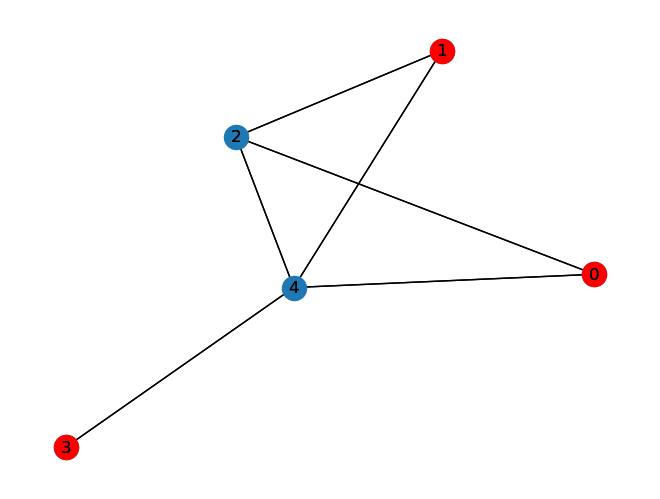

In [114]:
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=independent_set,
    node_color="r",
)

# For number of vertices = 6 , same steps as done previously are repeated

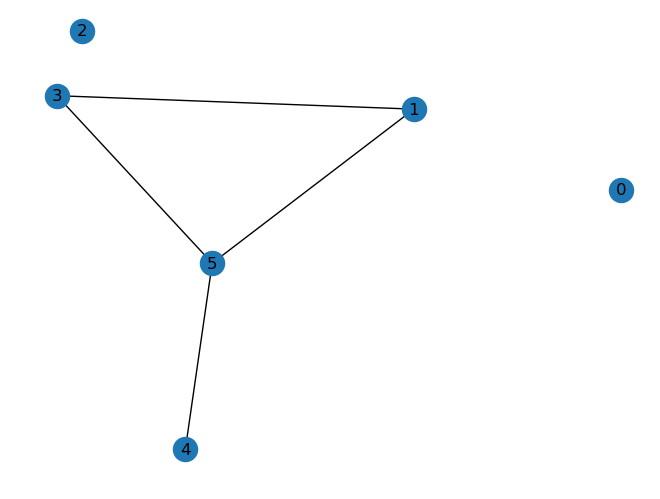

In [143]:
import networkx as nx

num_nodes = 6
p_edge = 0.4
graph = nx.fast_gnp_random_graph(n=num_nodes, p=p_edge, seed=12342)

nx.draw_kamada_kawai(graph, with_labels=True)
mis_model = mis(graph)

In [144]:
mis_model.pprint()

2 Set Declarations
    independent_rule_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    4 : {(1, 3), (1, 5), (3, 5), (4, 5)}
    x_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1, 2, 3, 4, 5}

1 Var Declarations
    x : Size=6, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : x[0] + x[1] + x[2] 

In [145]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3)

In [146]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

In [147]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=mis_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

In [148]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [149]:
with open("max_independent_set.qmod", "w") as f:
    f.write(qmod)

In [150]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/b34bb79f-85df-4000-aa77-c9d647714e56?version=0.38.0


In [151]:
from classiq import execute

res = execute(qprog).result()

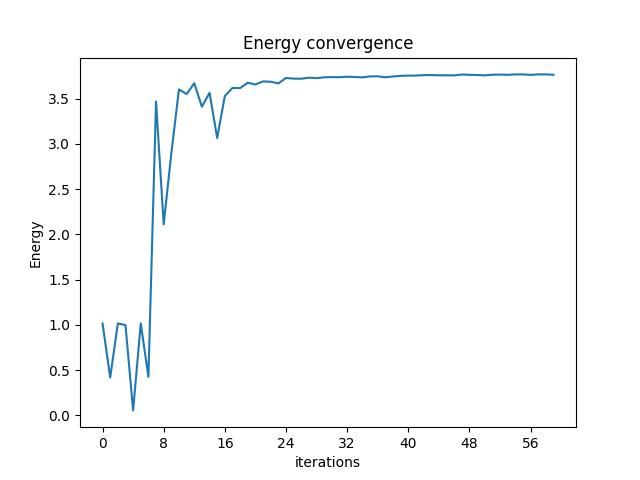

In [152]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

In [153]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    mis_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
0,0.282227,4.0,"[1, 0, 1, 1, 1, 0]",578
1,0.255859,4.0,"[1, 1, 1, 0, 1, 0]",524
7,0.014648,3.0,"[1, 0, 0, 1, 1, 0]",30
12,0.010254,3.0,"[1, 1, 1, 0, 0, 0]",21
11,0.012207,3.0,"[0, 0, 1, 1, 1, 0]",25


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

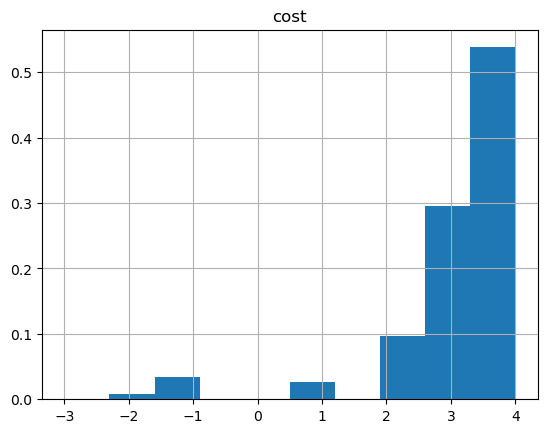

In [154]:
optimization_result.hist("cost", weights=optimization_result["probability"])

In [155]:
best_solution = optimization_result.solution[optimization_result.cost.idxmax()]

In [156]:
independent_set = [node for node in graph.nodes if best_solution[node] == 1]
print("Independent Set: ", independent_set)
print("Size of Independent Set: ", len(independent_set))

Independent Set:  [0, 2, 3, 4]
Size of Independent Set:  4


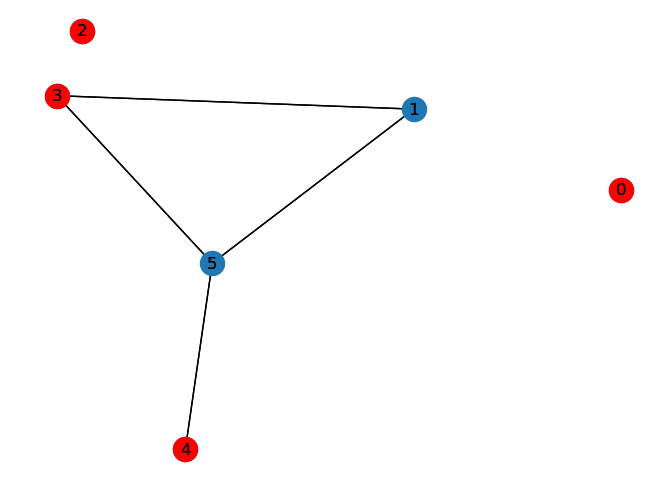

In [157]:
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=independent_set,
    node_color="r",
)

# For number of vertices = 7 , same steps as done previously are repeated

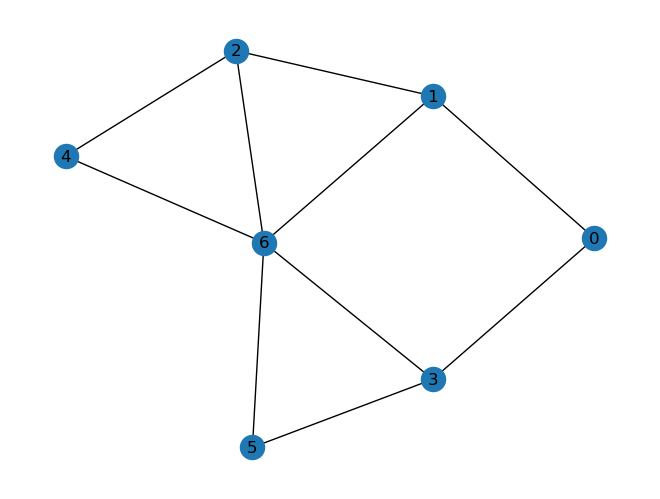

In [158]:
import networkx as nx

num_nodes = 7
p_edge = 0.4
graph = nx.fast_gnp_random_graph(n=num_nodes, p=p_edge, seed=11345)

nx.draw_kamada_kawai(graph, with_labels=True)
mis_model = mis(graph)

In [159]:
mis_model.pprint()

2 Set Declarations
    independent_rule_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   10 : {(0, 1), (0, 3), (1, 2), (1, 6), (2, 4), (2, 6), (3, 5), (3, 6), (4, 6), (5, 6)}
    x_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    7 : {0, 1, 2, 3, 4, 5, 6}

1 Var Declarations
    x : Size=7, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, 

In [160]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3)

In [161]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

In [162]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=mis_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

In [163]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [164]:
with open("max_independent_set.qmod", "w") as f:
    f.write(qmod)

In [165]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/6f6741a1-874a-4dde-8298-71870cfd0846?version=0.38.0


In [166]:
from classiq import execute

res = execute(qprog).result()

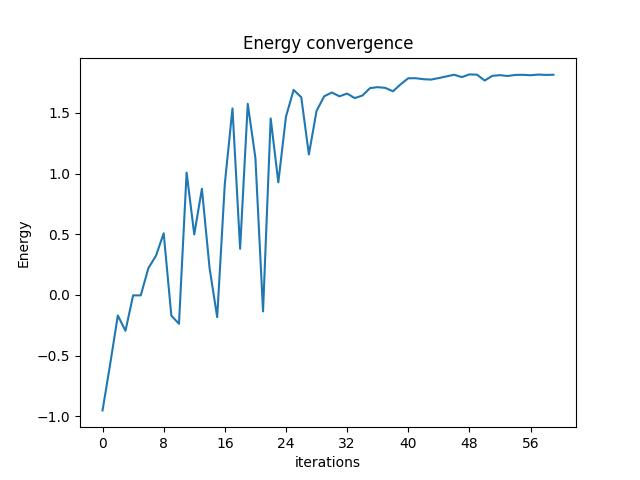

In [167]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

In [168]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    mis_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
0,0.087402,3.0,"[1, 0, 0, 0, 1, 1, 0]",179
2,0.046387,3.0,"[1, 0, 1, 0, 0, 1, 0]",95
4,0.042480,3.0,"[0, 1, 0, 0, 1, 1, 0]",87
6,0.032227,3.0,"[0, 1, 0, 1, 1, 0, 0]",66
88,0.002441,2.0,"[0, 1, 0, 1, 0, 0, 0]",5


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

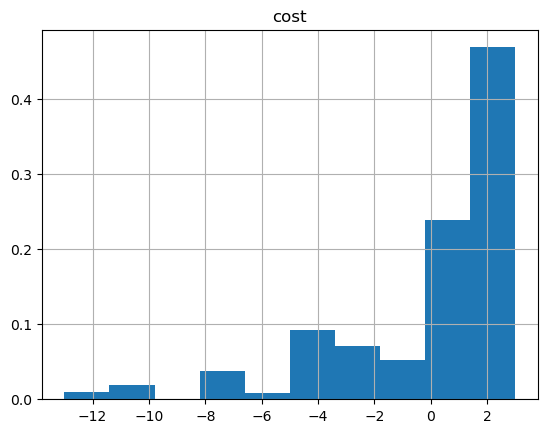

In [169]:
optimization_result.hist("cost", weights=optimization_result["probability"])

In [170]:
best_solution = optimization_result.solution[optimization_result.cost.idxmax()]

In [171]:
independent_set = [node for node in graph.nodes if best_solution[node] == 1]
print("Independent Set: ", independent_set)
print("Size of Independent Set: ", len(independent_set))

Independent Set:  [0, 4, 5]
Size of Independent Set:  3


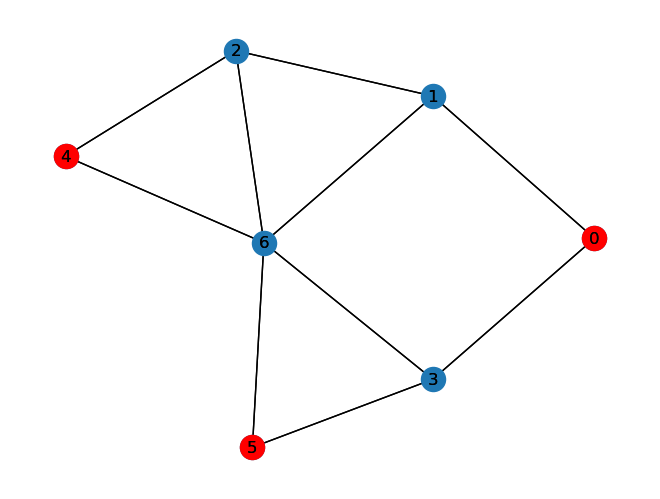

In [172]:
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=independent_set,
    node_color="r",
)


In summary, the code showcases how to interface with Classiq's quantum software, construct models using Pyomo, generate random graphs, and visualize the solutions to the MIS problem using NetworkX and matplotlib. The repeated sections indicate the code is modular and can be adapted for graphs of different sizes to solve the MIS problem using quantum computing techniques.


# **QUANTUM ADIABATIC ALGORITHM USING ANALOG BASED QUANTUM COMPUTING**


The below mentioned Python code is using the NetworkX library to create random graphs and the D-Wave's dimod library to solve the Maximum Independent Set (MIS) problem for each graph using a quantum annealing-based approach. Here's a breakdown of what each part of the code does:

1. **Imports Libraries**:
   - `networkx` for handling and creating complex networks (graphs).
   - `matplotlib.pyplot` for plotting graphs and solutions visually.
   - `dimod` for creating and solving binary quadratic models, typically used in quantum annealing.


In [173]:
import networkx as nx
import dimod


### Define Quantum Annealing Solver Function

- `solve_mis_quantum_annealing(graph)`: 
  - Generates a BQM for the MIS problem using the `dimod` library.
  - Solves the problem using `dimod.ExactSolver()`, a classical solver that exhaustively evaluates all possible solutions.
  
### Create Random Graphs

- The code generates four random graphs with varying node counts. The `nx.fast_gnp_random_graph()` function creates these graphs with a specified edge creation probability and a random seed for reproducibility.

### Solve and Plot MIS for Each Graph

- For each graph, the function:
  - Solves for the MIS using the previously defined function.
  - Separates the graph's nodes into MIS and non-MIS nodes.
  - Uses `matplotlib` to plot the graph, coloring the nodes according to whether they belong to the MIS (red) or not (blue).
  - Uses a spring layout to position the nodes visually.

### Print Results

- The nodes that belong to the MIS are printed out for each graph.

C:\Users\riakh\AppData\Local\Temp\ipykernel_29356\1497545607.py:15: DeprecationWarning: SampleSet.samples() will return an iterable not an iterator in the future
  solution = next(response.samples())


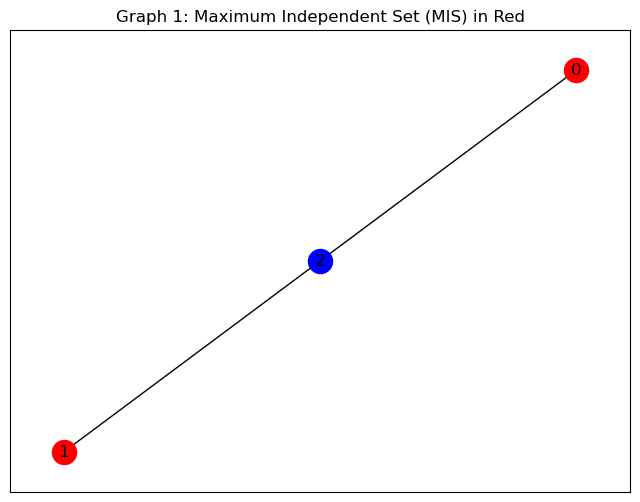

Solving MIS for Graph 1 with 3 nodes:
Maximum Independent Set: [0, 1]


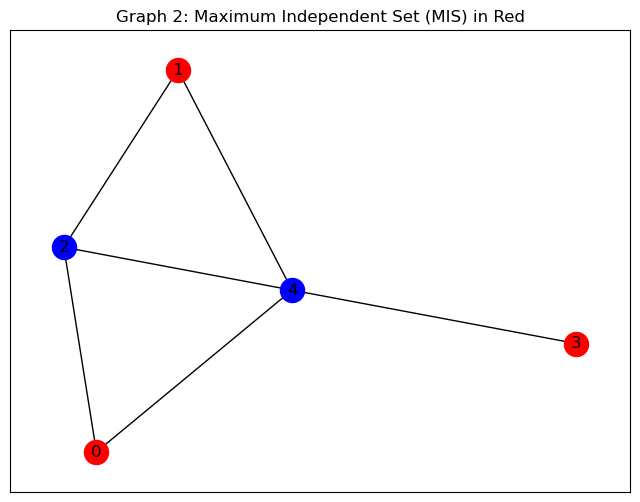

Solving MIS for Graph 2 with 5 nodes:
Maximum Independent Set: [0, 1, 3]


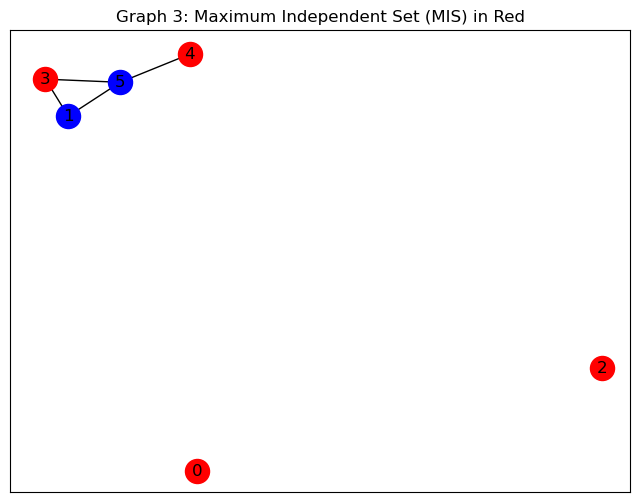

Solving MIS for Graph 3 with 6 nodes:
Maximum Independent Set: [0, 2, 3, 4]


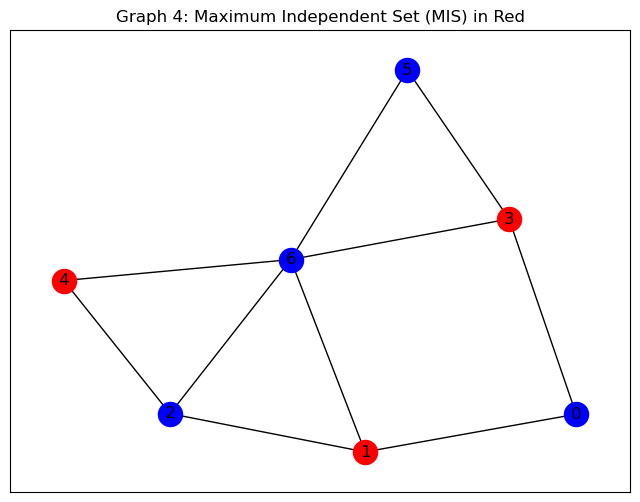

Solving MIS for Graph 4 with 7 nodes:
Maximum Independent Set: [1, 3, 4]


In [201]:
import networkx as nx
import matplotlib.pyplot as plt
import dimod

# Define the quantum annealing solver function
def solve_mis_quantum_annealing(graph):
    # Generate the maximum independent set problem
    mis_problem = dimod.generators.maximum_independent_set(graph.edges, graph.nodes)
    
    # Solve the problem using quantum annealing
    sampler = dimod.ExactSolver()
    response = sampler.sample(mis_problem)
    
    # Extract the solution
    solution = next(response.samples())
    
    return solution

# Define the graphs
graphs = [
    nx.fast_gnp_random_graph(n=3, p=0.4, seed=12345),
    nx.fast_gnp_random_graph(n=5, p=0.4, seed=12345),
    nx.fast_gnp_random_graph(n=6, p=0.4, seed=12342),
    nx.fast_gnp_random_graph(n=7, p=0.4, seed=11345)
]

# Solve MIS for each graph using quantum annealing and plot
for i, graph in enumerate(graphs, start=1):
    solution = solve_mis_quantum_annealing(graph)
    
    # Determine MIS and non-MIS nodes
    mis_nodes = [node for node, is_in_mis in solution.items() if is_in_mis]
    non_mis_nodes = list(set(graph.nodes()) - set(mis_nodes))

    # Plot the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph)
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_nodes(graph, pos, nodelist=mis_nodes, node_color='red', label='MIS Nodes')
    nx.draw_networkx_nodes(graph, pos, nodelist=non_mis_nodes, node_color='blue', label='Non-MIS Nodes')
    nx.draw_networkx_labels(graph, pos)
    
    # Display the graph
    plt.title(f"Graph {i}: Maximum Independent Set (MIS) in Red")
    plt.show()
    
    print(f"Solving MIS for Graph {i} with {len(graph.nodes())} nodes:")
    print("Maximum Independent Set:", mis_nodes)


# **Comparison of Gate Based QAOA and Quantum Adiabatic Algorithm using Analog Based Quantum Computing for MIS**

When comparing the two quantum approaches—the gate-based QAOA and the analog-based quantum adiabatic algorithm—for solving the Maximum Independent Set (MIS) problem, it's enlightening to dive deeper into the nuances that distinguish their operation and the potential implications for quantum computing as a field.

The QAOA, harnessing the power of gate-based quantum computing, leverages the superposition and entanglement of qubits to explore the solution space. The algorithm’s success hinges on the delicate balance of the quantum gates' parameter optimization, which is handled by a classical optimizer. The results for the QAOA method suggest not only that the parameters have been well-tuned but also that the quantum hardware is capable of maintaining coherence throughout the execution of the algorithm. This coherence is crucial for ensuring the constructive and destructive interference patterns, which QAOA relies on to amplify the probability of observing optimal or near-optimal solutions.

On the other hand, the quantum adiabatic algorithm, often realized on analog quantum computing platforms, is fundamentally different in its approach to solving optimization problems. It capitalizes on the adiabatic theorem, slowly evolving the quantum system's Hamiltonian from a trivial ground state to one that encodes the problem of interest. The images suggesting maximal independent sets indicate not only a carefully managed adiabatic process but also hint at the potential for analog quantum systems to address complex optimization problems efficiently. This could have significant implications for problems where adiabatic quantum computing might offer a more natural or robust approach compared to gate-based quantum computing.

Moreover, while QAOA's performance can be affected by gate errors and decoherence, adiabatic computing's main challenges lie in maintaining the system's evolution slow enough to avoid non-adiabatic transitions. In this respect, the quality of the adiabatic results speaks to the precision with which the quantum evolution has been controlled.

When comparing the effectiveness of the two methods, it is important to consider not just the accuracy of the final solutions but also the resources required to achieve them. For instance, QAOA might require fewer physical qubits but a more complex control scheme to implement the necessary quantum gates and classical optimization routines. In contrast, adiabatic quantum computing might require more qubits to implement the Hamiltonian but may benefit from longer coherence times and a potentially more straightforward mapping from problem to quantum hardware.

The instances depicted show that both quantum computation methods are quite promising for tackling optimization problems. These results may fuel further interest and research in quantum algorithms, driving advancements in both quantum hardware and algorithmic strategies. The current achievements, as seen in the provided images, encourage continued exploration and may pave the way for the eventual realization of quantum advantage in solving classically intractable problems.